Модуль для нормализации изображения найденного автомобильного номера. Нейросеть обучена на изображениях формата .jpg размером 1280\*720 и 1920\*1080. Маски подготовлены с помощью программы LabelImg.

In [ ]:
# коллабные импорты
from google.colab import drive
from google.colab import files


drive.mount('/GD',force_remount=True)

!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/data.zip .
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/masks_jpg.zip .
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/masks_jpg_predict.zip .
!cp -r /GD/'My Drive'/'Colab Notebooks'/PlateRecognition/detection_result.csv .

!unzip data.zip
!unzip masks_jpg.zip
!unzip masks_jpg_predict.zip

!mkdir plates_jpg
!mkdir plates_jpg_predict

In [2]:
import math
import sys
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd

from random import choice, sample
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN

In [3]:
df_result = pd.read_csv('detection_result.csv')
df_result.head(2)

,path_to_pics,path_to_true_mask,path_to_pred_mask,category,iou
0,pics_jpg/photo_45269@12-01-2022_01-57-11_0.jpg,masks_jpg/photo_45269@12-01-2022_01-57-11_0.jpg,masks_jpg_predict/photo_45269@12-01-2022_01-57...,train,NaN
1,pics_jpg/photo_44798@11-01-2022_16-35-50_360.jpg,masks_jpg/photo_44798@11-01-2022_16-35-50_360.jpg,masks_jpg_predict/photo_44798@11-01-2022_16-35...,train,0.671911


Предыдущий модуль передал нам маски-кляксы с содержащимися в них автомобильными номерами. Нужно решить 3 задачи:

- отделить маски друг от друга, если на одном фото несколько авто с номерами

- вырезать прямоугольники с номерами с каждой картинки

- нормализовать каждый прямоугольник

Сперва для работы будем использовать маски, размеченные человеком. На "нейросетевых" масках проверим работоспособность.

Для отделения кучек пикселей друг от друга, будем использовать кластеризацию DBScan. Применим проебразование Хафа для выделения главной линии (ожидается, что это будет горизонтальная линия номера). Далее, зная напрвление данной линии для каждого кластера, повернем номер в горизонтальное положение.

  0%|          | 0/5 [00:00<?, ?it/s]

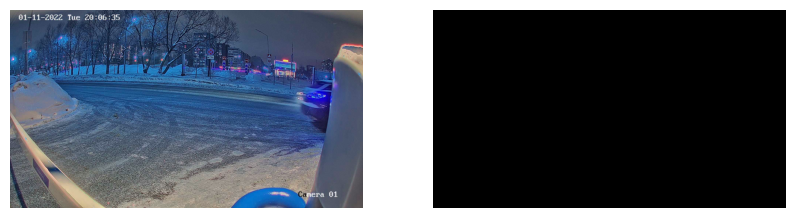

*************************


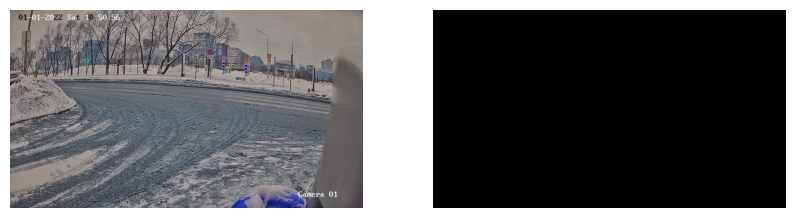

*************************


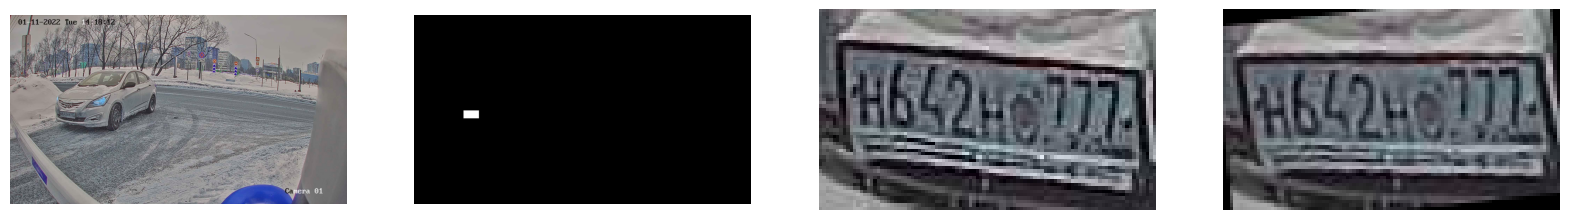

*************************


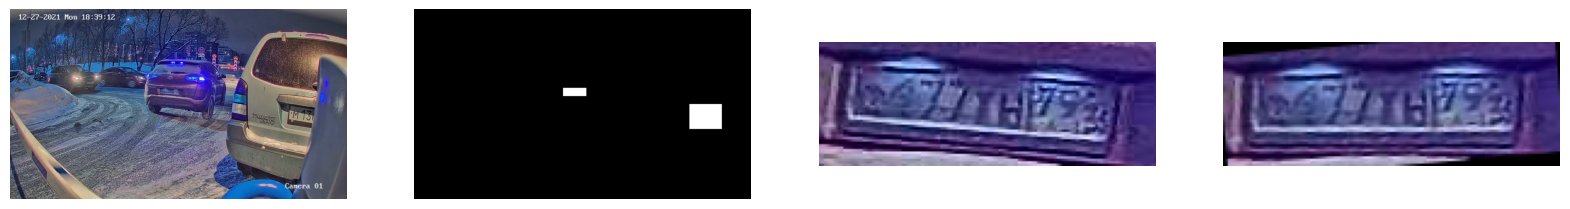

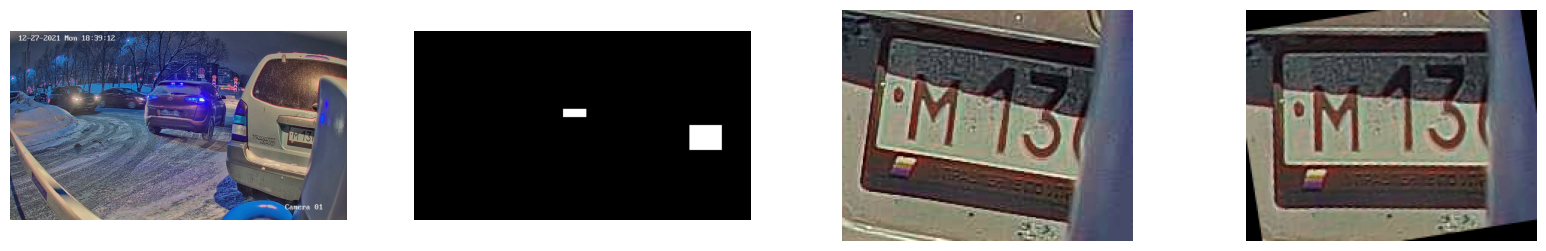

*************************


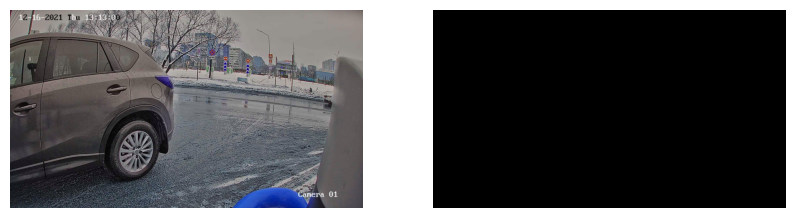

*************************


In [4]:
def hough_transform(image, edges, threshold=100):
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)

    if lines is not None:
        prime_line = lines[0][0]
        _, theta = prime_line

        height, width = image.shape[:2]
        center = (width // 2, height // 2)

        rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(theta - np.pi/2), 1.0)

        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)

        return rotated_image

    else:

        return image


indexis = sample(list(df_result.index), 5)

for ind in tqdm(indexis):

    mask = cv2.imread(df_result.iloc[ind]['path_to_true_mask'])
    image = cv2.imread(df_result.iloc[ind]['path_to_pics'])

    indices = np.argwhere(mask)
    pixels_array = np.array(indices)
    dbscan = DBSCAN(eps=25, min_samples=10)
    if pixels_array.any():
        labels = dbscan.fit_predict(pixels_array)

        df = pd.DataFrame({'y': pixels_array[:, 0],
                           'x': pixels_array[:, 1],
                           'cluster': labels})

        for cluster in df['cluster'].unique():
            y_min = df[df['cluster'] == cluster]['y'].min()
            x_min = df[df['cluster'] == cluster]['x'].min()

            y_max = df[df['cluster'] == cluster]['y'].max()
            x_max = df[df['cluster'] == cluster]['x'].max()

            y_min = max(0, y_min - 2)
            x_min = max(0, x_min - 2)

            y_max = min(image.shape[0], y_max + 2)
            x_max = min(image.shape[1], x_max + 2)

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))

            ax1.imshow(image)
            ax1.axis('off')

            ax2.imshow(mask)
            ax2.axis('off')

            cropped_image = image[y_min:y_max, x_min:x_max]
            ax3.imshow(cropped_image)
            ax3.axis('off')

            gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 300, 600)
            result = hough_transform(cropped_image, edges, threshold=45)
            ax4.imshow(result)
            ax4.axis('off')

            plt.show()
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

        ax1.imshow(image)
        ax1.axis('off')

        ax2.imshow(mask)
        ax2.axis('off')

        plt.show()

    print('*' * 25)

Проверим результат на масках, полученных от нейросети

  0%|          | 0/5 [00:00<?, ?it/s]

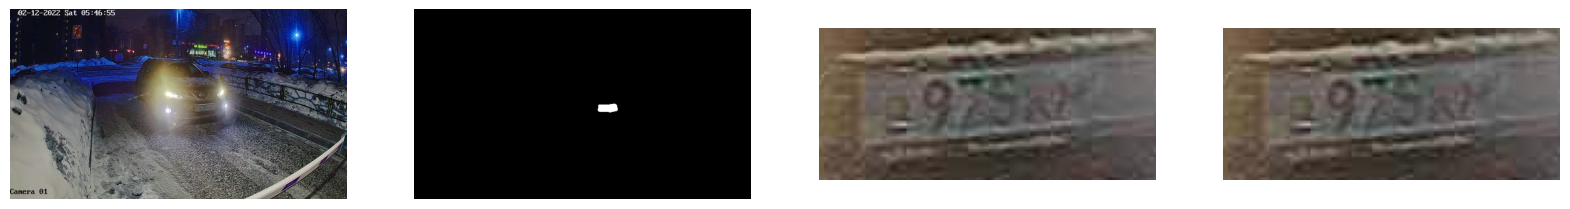

*************************


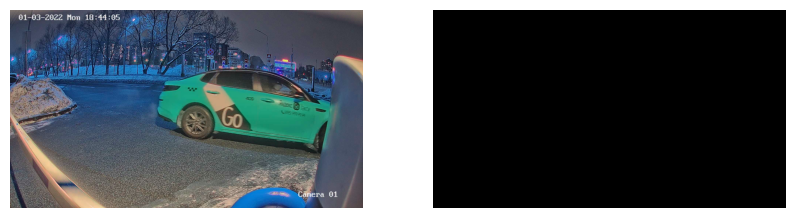

*************************


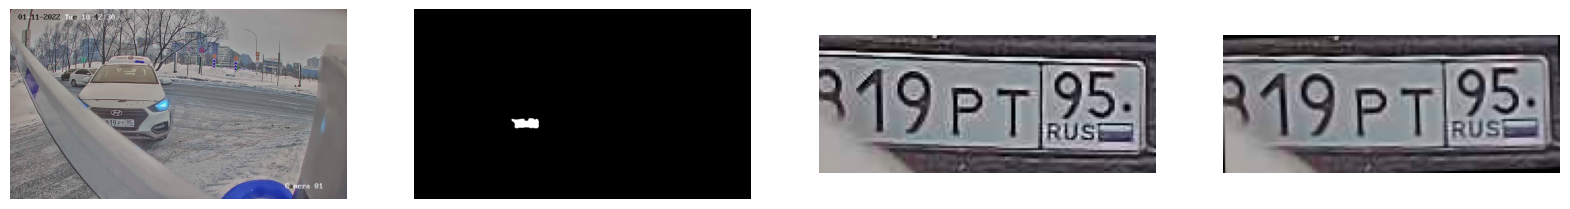

*************************


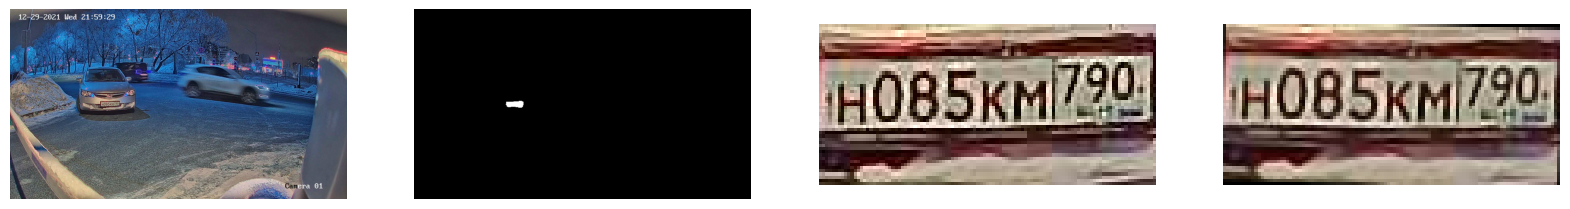

*************************


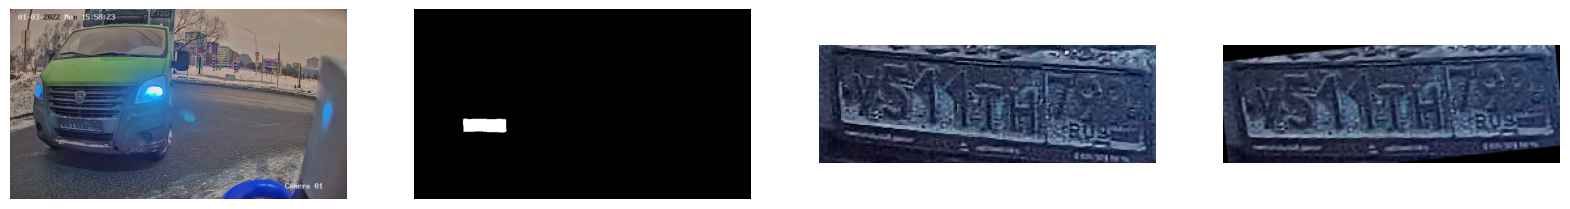

*************************


In [9]:
def hough_transform(image, edges, threshold=100):
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)

    if lines is not None:
        prime_line = lines[0][0]
        _, theta = prime_line

        height, width = image.shape[:2]
        center = (width // 2, height // 2)

        rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(theta - np.pi/2), 1.0)

        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)

        return rotated_image

    else:

        return image


indexis = sample(list(df_result.index), 5)

for ind in tqdm(indexis):

    mask = cv2.imread(df_result.iloc[ind]['path_to_pred_mask'])
    image = cv2.imread(df_result.iloc[ind]['path_to_pics'])

    indices = np.argwhere(mask)
    pixels_array = np.array(indices)
    dbscan = DBSCAN(eps=25, min_samples=10)
    if pixels_array.any():
        labels = dbscan.fit_predict(pixels_array)

        df = pd.DataFrame({'y': pixels_array[:, 0],
                           'x': pixels_array[:, 1],
                           'cluster': labels})

        for cluster in df['cluster'].unique():
            y_min = df[df['cluster'] == cluster]['y'].min()
            x_min = df[df['cluster'] == cluster]['x'].min()

            y_max = df[df['cluster'] == cluster]['y'].max()
            x_max = df[df['cluster'] == cluster]['x'].max()

            y_min = max(0, y_min - 2)
            x_min = max(0, x_min - 2)

            y_max = min(image.shape[0], y_max + 2)
            x_max = min(image.shape[1], x_max + 2)

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))

            ax1.imshow(image)
            ax1.axis('off')

            ax2.imshow(mask)
            ax2.axis('off')

            cropped_image = image[y_min:y_max, x_min:x_max]
            ax3.imshow(cropped_image)
            ax3.axis('off')

            gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 300, 600)
            result = hough_transform(cropped_image, edges, threshold=45)
            ax4.imshow(result)
            ax4.axis('off')

            plt.show()
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

        ax1.imshow(image)
        ax1.axis('off')

        ax2.imshow(mask)
        ax2.axis('off')

        plt.show()

    print('*' * 25)